# Load dataset

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")

    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)

        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")

    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [2]:
housing = load_housing_data()

# Show useful information about dataset

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info() # high level information about data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts() # check what categories (values under ocean_proximity) exist

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing.describe() # get high level numerical info

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


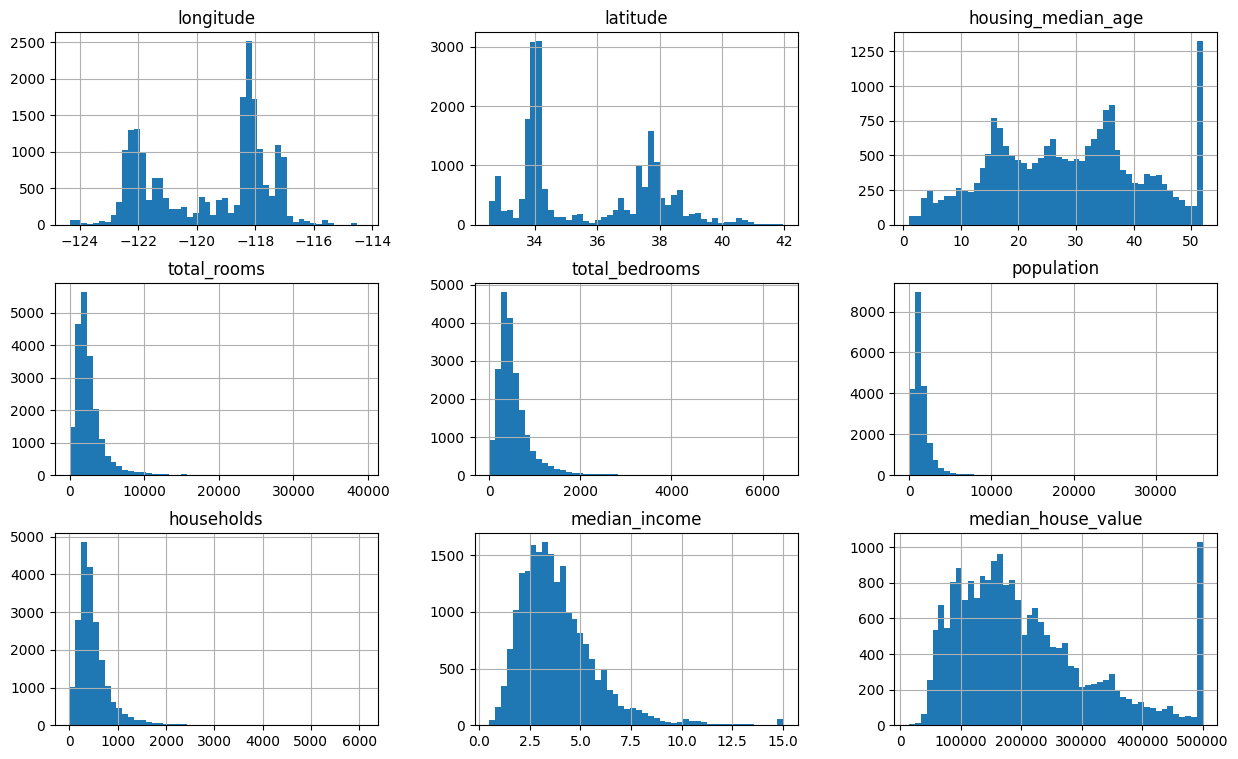

In [15]:
# get visual info about the numerical data
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(15, 9))
plt.show()

# Train/test split

## Simple implementation

In [7]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    # random generator seed can be set to return the same permutation array every run
    shuffled_indices = np.random.permutation(len(data))
    test_indices_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_indices_size]
    train_indices = shuffled_indices[test_indices_size:]

    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = shuffle_and_split_data(housing, 0.2) # issue is that test set changes after each run and model might eventually be trained on entire dataset

print(len(train_set))
print(len(test_set))

16512
4128


## Hash implementation to account for updated datasets

In [11]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32


def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id: is_id_in_test_set(id, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
# making unique id using lat/long
housing["identifier"] = housing["longitude"].apply(lambda x: str(x).replace(".", "")) + housing["latitude"].apply(lambda x: str(x).replace(".", ""))

train_set, test_set = split_data_with_id_hash(housing, 0.2, "identifier")

print(len(train_set))
print(len(test_set))

16611
4029


## sklearn train/test split

In [13]:
from sklearn.model_selection import train_test_split # similar to simple shuffle and split data function

train_set_sklearn, test_set_sklearn = train_test_split(housing, test_size=0.2, random_state=42)

print(len(train_set_sklearn))
print(len(test_set_sklearn))

16512
4128


# Housing income median strata

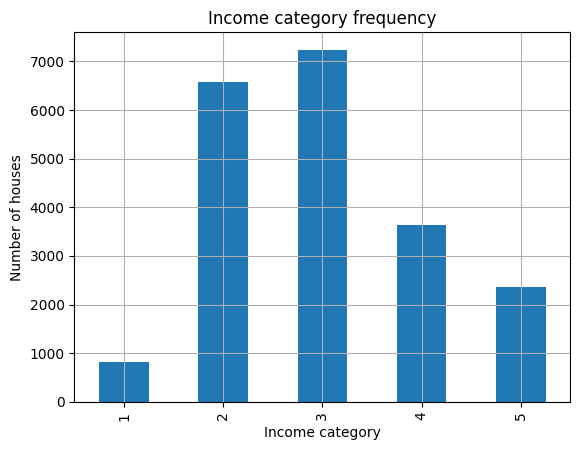

In [16]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])

housing["income_cat"].value_counts().sort_index().plot.bar(grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of houses")
plt.title("Income category frequency")
plt.show()

## Stratified shuffe split

In [18]:
"""
- now the train/test data have a similar distribution based on the median income
- this allows for a better representation of the data and hence model training
"""

from sklearn.model_selection import StratifiedShuffleSplit

stratified_splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_index, test_index in stratified_splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])


# instead of the above, can also be done as follows:
# strat_train_set, strat_test_set = train_test_split(housing, stratify=housing["income_cat"], test_size=0.2, random_state=42)

In [19]:
strat_train_set, strat_test_set = strat_splits[0]

## Comparing distribution of train/test set with original dataset

In [30]:
strat_train_proportions = strat_train_set["income_cat"].value_counts().sort_index() / len(strat_train_set)
strat_test_proportions = strat_test_set["income_cat"].value_counts().sort_index() / len(strat_test_set)
housing_proportions = housing["income_cat"].value_counts().sort_index() / len(housing)

comparison_df = pd.DataFrame({
    "Stratified Train Set": strat_train_proportions, 
    "Stratified Test Set": strat_test_proportions,
    "Original Housing Data": housing_proportions
})

comparison_df

,Stratified Train Set,Stratified Test Set,Original Housing Data
income_cat,,,
1,0.039789,0.039971,0.039826
2,0.318859,0.318798,0.318847
3,0.350594,0.350533,0.350581
4,0.176296,0.176357,0.176308
5,0.114462,0.114341,0.114438
